In [2]:
%matplotlib inline
import re
import sys
import matplotlib
import seaborn
import numpy
from matplotlib import pyplot as plt
from collections import defaultdict
import pandas

from evalutils import IntervalForest, populate_index_from_simulation, compact
import kevlar

seaborn.set_context({'figure.figsize': (12, 6)})
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

In [3]:
def roc_kevlar(filename, index, delta=30):
    reader = kevlar.vcf.VCFReader(kevlar.open(filename, 'r'))
    calls = compact(reader, index, delta=delta)
    nvariants = len(index.trees['chr17'])
    correct = 0
    false = 0
    tprs = list()
    for varcall in calls:
        valid = index.query(varcall.seqid, varcall.position, delta=delta) != set()
        if valid:
            correct += 1
            continue
        tpr = correct / nvariants
        tprs.append(tpr)
        false += 1
    return tprs

In [4]:
def roc_gatk(filename, index, delta=30):
    gatkdata = pandas.read_table('GATK_calls_30x.mvf.gz', sep='\t').sort_values('CHILD_DP', ascending=False)
    nvariants = len(index.trees['chr17'])
    correct = 0
    false = 0
    tprs = list()
    for rowindex, row in gatkdata.iterrows():
        valid = index.query(row['CHROM'], row['POS'], delta=delta) != set()
        if valid:
            correct += 1
            continue
        tpr = correct / nvariants
        tprs.append(tpr)
        false += 1
    return tprs

In [5]:
index = populate_index_from_simulation('SimulatedVariants_chr17_hg38.tsv.gz', 'chr17')

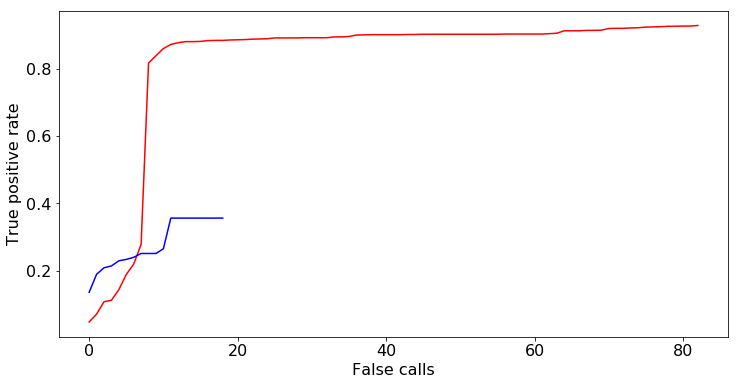

In [6]:
kevlar30x = roc_kevlar('kevlar_calls_30x.vcf.gz', index)
gatk30x = roc_gatk('GATK_calls_30x.mvf.gz', index)

_ = plt.plot(range(len(kevlar30x)), kevlar30x, color='red')
_ = plt.plot(range(len(gatk30x)), gatk30x, color='blue')
_ = plt.xlabel('False calls')
_ = plt.ylabel('True positive rate')